# Train RoadMapper model 

This notebook trains a model to take in six images from the car's point of view, and output a bird's eye view map of the road.

It currently uses a modified version of [HRNet](https://github.com/HRNet/HRNet-Semantic-Segmentation) (Wang et. al. 2020).

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

from hrnet import get_seg_model
from hrnet_sixinput import get_seg_model_sixinput

#!pip install yacs
from yacs.config import CfgNode as CN

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [4]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/bs3743/DL-TopDownRoad/data'
annotation_csv = '/scratch/bs3743/DL-TopDownRoad/data/annotation.csv'

### Read in the labeled training data, and split into a training and validation set

In [5]:
# The scenes from 106 - 133 are labeled
labeled_scene_index = np.arange(106, 134)

In [6]:
# Split 75/25 into training and validation
random.shuffle(labeled_scene_index)
labeled_scene_index_train = labeled_scene_index[0:21]
labeled_scene_index_val = labeled_scene_index[21:28]
print("Train scenes: {} \nVal scenes: {}".format(len(labeled_scene_index_train), len(labeled_scene_index_val)))

Train scenes: 21 
Val scenes: 7


In [7]:
transform = torchvision.transforms.ToTensor()

In [8]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_train,
                                  transform=transform,
                                  extra_info=False
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [9]:
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_val,
                                  transform=transform,
                                  extra_info=False
                                 )
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [10]:
sample, target, road_image = iter(trainloader).next()
print(torch.stack(sample).shape)
#print(torch.stack(sample)[:, 1, :, :].shape)

torch.Size([2, 6, 3, 256, 306])


### Train the model

In [11]:
# Create model config
# Note: I need to clean this up and move the whole config to a seperate file with the rest of it 

config = CN(new_allowed=True)
config.defrost()
config.merge_from_file("hrnet_config.yaml")
config.TRAIN.LR = 10e-4
config.freeze()

In [12]:
# Initialize model
#model = get_seg_model(config)
model = get_seg_model_sixinput(config)
model = model.to(device)

In [13]:
# Intialize loss
loss = nn.BCELoss()

In [14]:
# Intialize optimizer
optimizer = torch.optim.SGD([{'params':
                                  filter(lambda p: p.requires_grad,
                                         model.parameters()),
                                  'lr': config.TRAIN.LR}],
                                lr=config.TRAIN.LR,
                                momentum=config.TRAIN.MOMENTUM,
                                weight_decay=config.TRAIN.WD,
                                nesterov=config.TRAIN.NESTEROV,
                                )

In [15]:
# Create training function
def train(train_loader, model, optimizer, criterion, epoch, sixinput):
    
    model.train()

    for batch_idx, (sample, target, road_image) in enumerate(train_loader):
        
        # Send to device
        sample, road_image = torch.stack(sample).to(device),  torch.stack(road_image).float().to(device) # takes only one image for now
        
        # Make input the correct shape
        if sixinput==False:
            batch_size = sample.shape[0]
            sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])
        
        # Run through model
        optimizer.zero_grad()
        output = model(sample)
        
        # Calculate loss and take step
        loss = criterion(output, road_image)
        loss.backward()
        optimizer.step()
        
        # Log progress
        if batch_idx % 100 == 0:
            print('\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
    return


In [16]:
# Create an evaluation function
def evaluate(val_loader, model, criterion, sixinput):
    model.eval()
    losses = []
    tp, fp, fn = 0, 0, 0
    for batch_idx, (sample, target, road_image) in enumerate(val_loader):
        # send to device
        sample, road_image = torch.stack(sample).to(device), torch.stack(road_image).float().to(device) # takes only one image for now
        
        # Make input the correct shape
        if sixinput==False:
            batch_size = sample.shape[0]
            sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])
        
        with torch.no_grad():
            output = model(sample)
            
        # Calculate loss
        loss = criterion(output, road_image)
        losses.append(loss)
        
        # Calculate TP, FP, FN for threat score
        output_class = (output > 0.5).float()
        tp = tp + torch.sum(torch.mul(output_class, road_image))
        fp = fp + torch.sum(torch.mul(torch.eq(output_class, 1), torch.eq(road_image, 0)))
        fn = fn + torch.sum(torch.mul(torch.eq(output_class, 0), torch.eq(road_image, 1)))
    
    # Calculate metrics
    loss = sum(losses)/len(losses)
    threat_score = tp/(tp+fp+fn)
    
    return loss, threat_score


In [17]:
# Train

max_val_threat_score = 0
val_threat_score_hist = []
val_loss_hist = []

for epoch in range(30):
    
    # Train for one epoch
    train(trainloader, model, optimizer, loss, epoch, sixinput=True)
    
    # Evaluate at the end of the epoch
    print("Evaluating after Epoch {}:".format(epoch))
    val_loss, val_threat_score = evaluate(valloader, model, loss, sixinput=True)
    print("Val loss is {:.6f}, threat score is {:.6f}".format(val_loss, val_threat_score))
    
    # If this is the best model so far, save it
    if val_threat_score > max_val_threat_score:
        torch.save({
            'epoch': epoch,
            'config': config,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_threat_score': val_threat_score,
            }, 'models/best_road_mapper_lr10e-4_sixinput.pt')
    
    # Save loss 
    val_loss_hist.append(val_loss)
    val_threat_score_hist.append(val_threat_score)

checkpoint = torch.load('models/best_road_mapper_lr10e-4_sixinput.pt')
checkpoint['val_loss_hist'] = val_loss_hist
checkpoint['val_threat_score_hist'] = val_threat_score_hist
torch.save(checkpoint, 'models/best_road_mapper_lr10e-4_sixinput.pt')

/home/bs3743/.conda/envs/nlp/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/bs3743/.conda/envs/nlp/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


	Train Epoch: 0 [0/2646 (0%)]	Loss: 0.692974
	Train Epoch: 0 [200/2646 (8%)]	Loss: 0.582035
	Train Epoch: 0 [400/2646 (15%)]	Loss: 0.204237
	Train Epoch: 0 [600/2646 (23%)]	Loss: 0.545625
	Train Epoch: 0 [800/2646 (30%)]	Loss: 0.250387
	Train Epoch: 0 [1000/2646 (38%)]	Loss: 0.354239
	Train Epoch: 0 [1200/2646 (45%)]	Loss: 0.456873
	Train Epoch: 0 [1400/2646 (53%)]	Loss: 0.389548
	Train Epoch: 0 [1600/2646 (60%)]	Loss: 0.231393
	Train Epoch: 0 [1800/2646 (68%)]	Loss: 0.344086
	Train Epoch: 0 [2000/2646 (76%)]	Loss: 0.218324
	Train Epoch: 0 [2200/2646 (83%)]	Loss: 0.362546
	Train Epoch: 0 [2400/2646 (91%)]	Loss: 0.336886
	Train Epoch: 0 [2600/2646 (98%)]	Loss: 0.498642
Evaluating after Epoch 0:
Val loss is 0.488559, threat score is 0.590296
	Train Epoch: 1 [0/2646 (0%)]	Loss: 0.298927
	Train Epoch: 1 [200/2646 (8%)]	Loss: 0.361563
	Train Epoch: 1 [400/2646 (15%)]	Loss: 0.359587
	Train Epoch: 1 [600/2646 (23%)]	Loss: 0.559904
	Train Epoch: 1 [800/2646 (30%)]	Loss: 0.206549
	Train Epoch: 

Val loss is 0.540935, threat score is 0.676210
	Train Epoch: 11 [0/2646 (0%)]	Loss: 0.148851
	Train Epoch: 11 [200/2646 (8%)]	Loss: 0.046341
	Train Epoch: 11 [400/2646 (15%)]	Loss: 0.047554
	Train Epoch: 11 [600/2646 (23%)]	Loss: 0.049983
	Train Epoch: 11 [800/2646 (30%)]	Loss: 0.058752
	Train Epoch: 11 [1000/2646 (38%)]	Loss: 0.236840
	Train Epoch: 11 [1200/2646 (45%)]	Loss: 0.082243
	Train Epoch: 11 [1400/2646 (53%)]	Loss: 0.151142
	Train Epoch: 11 [1600/2646 (60%)]	Loss: 0.044076
	Train Epoch: 11 [1800/2646 (68%)]	Loss: 0.104811
	Train Epoch: 11 [2000/2646 (76%)]	Loss: 0.115605
	Train Epoch: 11 [2200/2646 (83%)]	Loss: 0.092816
	Train Epoch: 11 [2400/2646 (91%)]	Loss: 0.078814
	Train Epoch: 11 [2600/2646 (98%)]	Loss: 0.117944
Evaluating after Epoch 11:
Val loss is 0.630816, threat score is 0.677874
	Train Epoch: 12 [0/2646 (0%)]	Loss: 0.113780
	Train Epoch: 12 [200/2646 (8%)]	Loss: 0.161554
	Train Epoch: 12 [400/2646 (15%)]	Loss: 0.077303
	Train Epoch: 12 [600/2646 (23%)]	Loss: 0.026

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/bs3743/.conda/envs/nlp/lib/python3.6/multiprocessing/connectio

KeyboardInterrupt: 

In [19]:
# Load saved model
checkpoint = torch.load('models/best_road_mapper_lr10e-5_sixinput.pt')
model = get_seg_model_sixinput(checkpoint['config'])
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

Text(0.5, 0, 'Epoch')

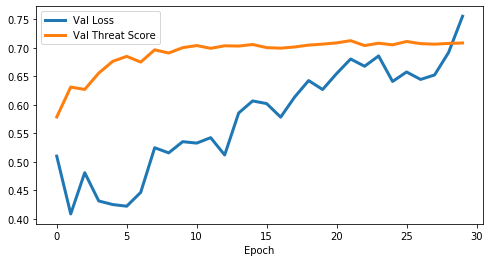

In [20]:
# Plot loss vs threat score during training
matplotlib.rcParams['figure.figsize'] = [8, 4]
plt.plot(list(range(len(checkpoint['val_loss_hist']))), checkpoint['val_loss_hist'], label="Val Loss", linewidth=3)
plt.plot(list(range(len(checkpoint['val_loss_hist']))), checkpoint['val_threat_score_hist'], label="Val Threat Score", linewidth=3)
plt.legend()
plt.xlabel('Epoch')

In [ ]:
matplotlib.rcParams['figure.figsize'] = [2, 2]

# Visualize results
sample, target, road_image = iter(valloader).next()
image = sample[0][None, :, :, :]
#plt.imshow(image.numpy().transpose(1, 2, 0))
#plt.axis('off')
# True road image
fig, ax = plt.subplots()
ax.imshow(road_image[0], cmap='binary')

In [ ]:
# Predicted road image
output = model(image.to(device))
fig, ax = plt.subplots()
ax.imshow(output.cpu().detach().numpy().squeeze(0), cmap='binary')
plt.show()

In [ ]:
# Predicted road image, with threshold
output_binary = output[0, :, :] > 0.5
fig, ax = plt.subplots()
ax.imshow(output_binary.cpu().detach().numpy(), cmap='binary')

In [2]:
# Check which model is best
lrs = ["10e-4", "10e-5", "10e-6"]
sixinput_opts = ["", "_sixinput"]

for lr in lrs:
    
    for sixinput_opt in sixinput_opts:
         
        model_path = 'models/best_road_mapper_lr{}{}.pt'.format(lr, sixinput_opt)
        checkpoint = torch.load(model_path)
        print("\nLearning rate: ", lr)
        print("Sixinput: ", "True"if sixinput_opt !="" else "False")
        print("Model path: ", model_path)
        print("Validation threat score: ", checkpoint['val_threat_score'])


Learning rate:  10e-4
Sixinput:  False
Model path:  models/best_road_mapper_lr10e-4.pt
Validation threat score:  tensor(0.6924, device='cuda:0')

Learning rate:  10e-4
Sixinput:  True
Model path:  models/best_road_mapper_lr10e-4_sixinput.pt
Validation threat score:  tensor(0.6909, device='cuda:0')

Learning rate:  10e-5
Sixinput:  False
Model path:  models/best_road_mapper_lr10e-5.pt
Validation threat score:  tensor(0.7001, device='cuda:0')

Learning rate:  10e-5
Sixinput:  True
Model path:  models/best_road_mapper_lr10e-5_sixinput.pt
Validation threat score:  tensor(0.7083, device='cuda:0')

Learning rate:  10e-6
Sixinput:  False
Model path:  models/best_road_mapper_lr10e-6.pt
Validation threat score:  tensor(0.6925, device='cuda:0')

Learning rate:  10e-6
Sixinput:  True
Model path:  models/best_road_mapper_lr10e-6_sixinput.pt
Validation threat score:  tensor(0.6780, device='cuda:0')
